In [9]:
import sys
sys.path.append('./')

In [10]:
import pandas as pd
import numpy as np
from constants import PROCESSED_DF_PATH
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import xgboost as xgb
from utils import plot_confussion_matrix, save_model, load_model, model_exists, test_model_dict, clean_text, test_model

In [11]:
# Leemos nuestro dataset ya procesado
df = pd.read_csv(PROCESSED_DF_PATH)

In [12]:
df.head()

,text,category
0,love amazing color black really hard see alway...,2
1,really like consistent bright throughout size ...,0
2,grand niece enjoy game,0
3,let say first unboxed mouse review base little...,1
4,kid love game he s,0


In [13]:
# Separamos en sets para train y test
X = df['text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [14]:
# Instanciamos el modelo de tfidf_vectorizer para realizar la codificación del texto
tfidf_vectorizer  = TfidfVectorizer(
    max_df = .95,
    min_df = 3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 2)
)

He escogido los parámetros del vectorizer de acuerdo a mi conocimiento del dominio. 
* Eliminaremos palabras que sean muy comunes y que tal vez no tengan un valor significativo para nuestra predicción al no aportar nada.
* Y de igual manera palabras muy extrañas o que tal vez sean errores ortográficos que no aportan nada serán eliminados.
* Nos quedaremos con un vocabulario de solamente `2500`, que serán las palabras con mayor peso sobre las reviews.
* En caso de que se haya filtrado algún intruso como caracteres con tildes o cosas raras, las vamos a transformar
* Y por ultimo no tomaremos solo en cuenta palabras solas, sino también bi-gramas, ya que hay bi-gramas como "bad - product", que pueden aportar mucho al modelo.

In [15]:
TFIDF_MODEL_NAME = 'tfidf_model.pkl'
MODEL_TYPE = 'ml'

if model_exists(TFIDF_MODEL_NAME, MODEL_TYPE):
    tfidf_vectorizer = load_model(TFIDF_MODEL_NAME, MODEL_TYPE)
else:
    tfidf_vectorizer = tfidf_vectorizer.fit(X_train)
    save_model(tfidf_vectorizer, TFIDF_MODEL_NAME, MODEL_TYPE)

# Entrenamos el codificador con el set de X_train
X_train_vectorized = tfidf_vectorizer.transform(X_train)

# Usamos el codificador entrenando para convertir X_test
X_test_vectorized = tfidf_vectorizer.transform(X_test)

# Regresión Logística con gridSearch
Ya que el algoritmo de regresión logística no es tan costoso computacionalmente podemos usar un gridsearch para encontrar los mejores parámetros

In [16]:
# Nombre del modelo de regresión logística
LR_MODEL_NAME = 'logistic_regression.pkl'

# Verificamos si el modelo ya existe
if model_exists(LR_MODEL_NAME, MODEL_TYPE):
    lr_model = load_model(LR_MODEL_NAME, MODEL_TYPE)
# Si el modelo no existe lo instanciamos y entrenamos
else:
    # Instanciamos el modelo de regresión logística bajo una capa OVR
    base_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
    
    # Definimos los diferentes hiperparámetros a utilizar
    param_grid = {
        'estimator__C': [0.01, 0.1, 1, 5],
        'estimator__max_iter': [50, 100, 250, 500]
    }
    
    # Instanciamos GridSearchCV
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Entrenamos el GridSearchCV
    grid_search.fit(X_train_vectorized, y_train)
    
    # Mostramos los mejores resultados e hiperparámetros
    print("Mejor score:", grid_search.best_score_)
    print("Mejores hiperparámetros:", grid_search.best_params_)    

    # Nos quedamos con el mejor modelo
    lr_model = grid_search.best_estimator_
    
    # Guardamos el modelo
    save_model(lr_model, LR_MODEL_NAME, MODEL_TYPE)

In [18]:
# Predecimos sobre el set de test
y_pred_lr = lr_model.predict(X_test_vectorized)

# Vamos a ver como se comporta el modelo con las diferentes clases
labels = ['Bueno', 'Malo', 'Neutral']
print(classification_report(y_test, y_pred_lr, target_names=labels))

              precision    recall  f1-score   support

       Bueno       0.69      0.72      0.70     17745
        Malo       0.65      0.70      0.67     18886
     Neutral       0.54      0.48      0.51     18821

    accuracy                           0.63     55452
   macro avg       0.63      0.63      0.63     55452
weighted avg       0.62      0.63      0.63     55452



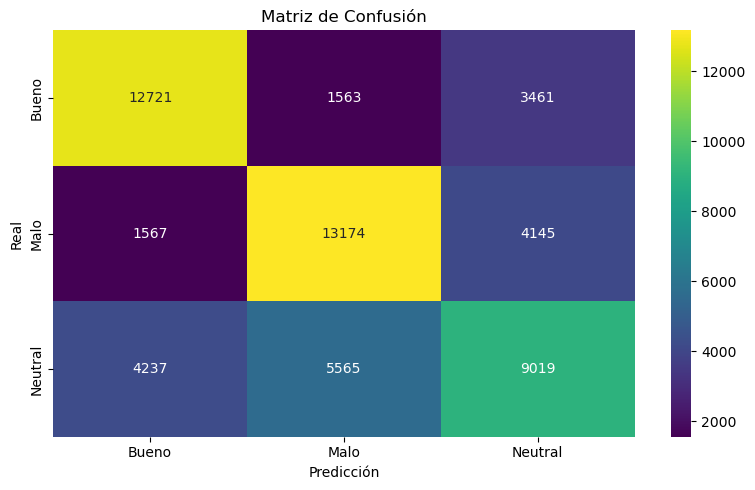

In [19]:
# Graficamos la matriz de confusión
plot_confussion_matrix(y_test, y_pred_lr, labels)

In [20]:
sample_reviews = {
    "Bueno": [
        "This product exceeded my expectations!",
        "Absolutely fantastic service.",
        "I loved it, would definitely buy again.",
        "Great quality and fast shipping.",
        "One of the best purchases I’ve ever made."
    ],
    "Malo": [
        "This is the worst thing I’ve ever bought.",
        "Terrible experience, do not recommend.",
        "Completely useless and broke after a day.",
        "Very disappointed with this product.",
        "Waste of money and time."
    ],
    "Neutral": [
        "It’s okay, nothing special.",
        "Average product, works as expected.",
        "Neither good nor bad.",
        "Just fine, does the job.",
        "It’s acceptable for the price."
    ]
}

In [21]:
test_model_dict(sample_reviews, lr_model, tfidf_vectorizer, labels)

Valor real                Valor predicho
Bueno                              Bueno
Bueno                              Bueno
Bueno                              Bueno
Bueno                              Bueno
Bueno                              Bueno
Malo                                Malo
Malo                                Malo
Malo                                Malo
Malo                                Malo
Malo                                Malo
Neutral                          Neutral
Neutral                          Neutral
Neutral                             Malo
Neutral                          Neutral
Neutral                          Neutral


# Modelo #2 Multinomial Naive Bayes
Al igual que en regresión, con este modelo también podemos permitirnos usar GridSearch 

In [22]:
MULTINOMIALNB_MODEL_NAME = 'multinomialnb_model.pkl'

if model_exists(MULTINOMIALNB_MODEL_NAME, MODEL_TYPE):
    mbn_model = load_model(MULTINOMIALNB_MODEL_NAME, MODEL_TYPE)
else:
    base_model = MultinomialNB()
    
    param_grid = {
    'alpha': [3.0, 5.0, 10.0, 15.0], 
    'fit_prior': [True, False]  
}
    
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    
    grid_search.fit(X_train_vectorized, y_train)

    print("Mejor score:", grid_search.best_score_)
    print("Mejores hiperparámetros:", grid_search.best_params_)  

    mbn_model = grid_search.best_estimator_
    
    save_model(mbn_model, MULTINOMIALNB_MODEL_NAME, MODEL_TYPE)

In [24]:
y_pred_mnb = mbn_model.predict(X_test_vectorized)

print(classification_report(y_test, y_pred_mnb, target_names=labels))

              precision    recall  f1-score   support

       Bueno       0.67      0.68      0.68     17745
        Malo       0.65      0.64      0.65     18886
     Neutral       0.51      0.51      0.51     18821

    accuracy                           0.61     55452
   macro avg       0.61      0.61      0.61     55452
weighted avg       0.61      0.61      0.61     55452



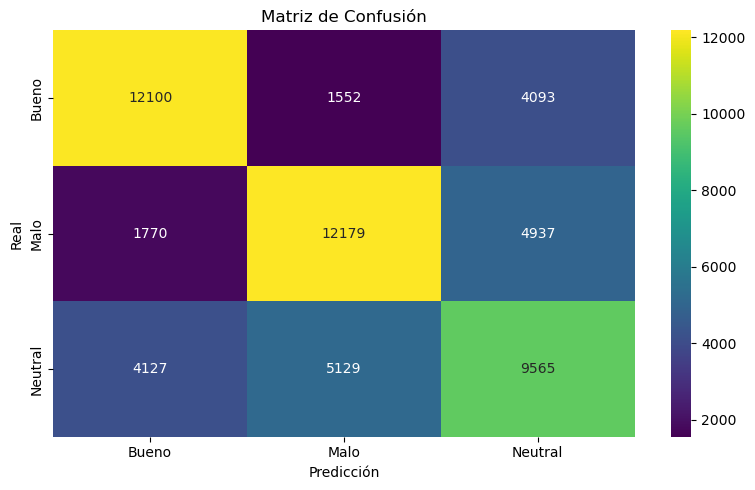

In [26]:
plot_confussion_matrix(y_test, y_pred_mnb, labels)

In [28]:
test_model_dict(sample_reviews, lr_model, tfidf_vectorizer, labels)


Valor real                Valor predicho
Bueno                              Bueno
Bueno                              Bueno
Bueno                              Bueno
Bueno                              Bueno
Bueno                              Bueno
Malo                                Malo
Malo                                Malo
Malo                                Malo
Malo                                Malo
Malo                                Malo
Neutral                          Neutral
Neutral                          Neutral
Neutral                             Malo
Neutral                          Neutral
Neutral                          Neutral


# Modelo ensamblado XGBoosting

In [31]:
# Vamos a pasar los datos a un tipo de estructura que es más eficiente con este modelo
d_train = xgb.DMatrix(X_train_vectorized, label=y_train)
d_test = xgb.DMatrix(X_test_vectorized, label=y_test)

In [32]:
XGB_MODEL_NAME = 'xgb_model.pkl'
ROUNDS = 100
if model_exists(XGB_MODEL_NAME, MODEL_TYPE):
    xgb_model = load_model(XGB_MODEL_NAME, MODEL_TYPE)
else:
    xgb_params = {
    'objective': 'multi:softmax',  
    'num_class': 3,                
    'max_depth': 6,                
    'eta': 0.3,                    
    'eval_metric': 'merror'
    }
    
    xgb_model = xgb.train(xgb_params, d_train, ROUNDS)

    save_model(xgb_model, XGB_MODEL_NAME, MODEL_TYPE)

In [34]:
y_pred_xgb = xgb_model.predict(d_test)

print(classification_report(y_test, y_pred_xgb, target_names=labels))

              precision    recall  f1-score   support

       Bueno       0.69      0.65      0.67     17745
        Malo       0.62      0.69      0.65     18886
     Neutral       0.52      0.48      0.50     18821

    accuracy                           0.61     55452
   macro avg       0.61      0.61      0.61     55452
weighted avg       0.61      0.61      0.61     55452



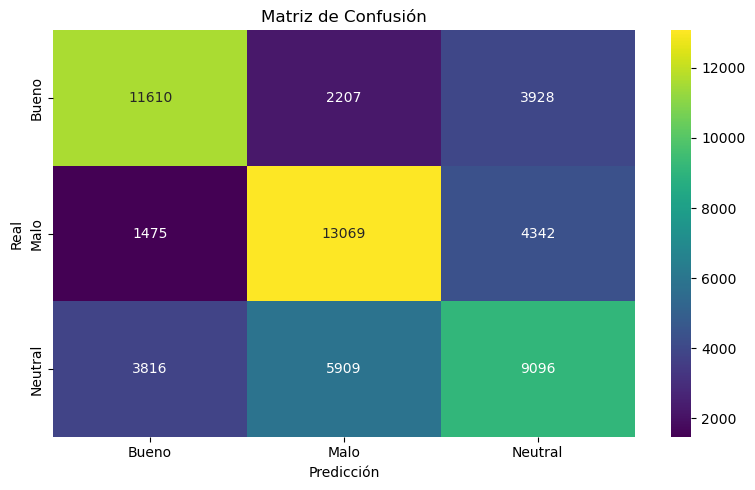

In [36]:
plot_confussion_matrix(y_test, y_pred_xgb, labels)

In [37]:
for label, reviews in sample_reviews.items():
    print(f'Valor real{"Valor Predicho".rjust(25)}')
    for review in reviews:
        review = tfidf_vectorizer.transform([clean_text(review)])
        pred = xgb_model.predict(xgb.DMatrix(review))
        print(f'{label}{labels[pred[0].astype(np.int8)].rjust(25)}')

Valor real           Valor Predicho
Bueno                     Malo
Bueno                    Bueno
Bueno                    Bueno
Bueno                    Bueno
Bueno                    Bueno
Valor real           Valor Predicho
Malo                     Malo
Malo                     Malo
Malo                     Malo
Malo                     Malo
Malo                     Malo
Valor real           Valor Predicho
Neutral                  Neutral
Neutral                  Neutral
Neutral                  Neutral
Neutral                  Neutral
Neutral                    Bueno


# Conclusión final
Habiendo usado tres modelos diferentes desde uno simple hasta algo un poco más complejo, podemos ver que los tres siguen una tendencia similar; Teniendo carencias con la categoria Neutral, y bastante mejores con las otras dos.

Pienso que esto pudo haber ocurrido debido a como se realizo el etiquetado de las muestras, ya que la categoría neutral al ser reviews de 3 estrellas pueden llegar a ser menos sutiles/evidentes lo que haría que a estos modelos se les complique encontrar patrones en cuanto a su sentimiento o tono a diferencia de categorías más negativas o positivas que suele estar más cargado de emociones.

De todas maneras lo curioso es que el modelo más simple (Regresión logística) fue el que mejor resultado me dió, es el que mejor se comporta a nivel general, mientras que el modelo MultinomialNB tiene un recall más bajo en las categorías malo/bueno, pero de acuerdo a su matriz de confusión es un poco mejor en neutral, pero no creo que esa pequeña mejora valga la perdida en las otras dos clases. 

In [41]:
text = "This one of the best products I have ever bought, I would totally recommend it to a friend!"
print(test_model(text, lr_model, tfidf_vectorizer, labels))
print(test_model(text, mbn_model, tfidf_vectorizer, labels))

Bueno
Bueno
